In [1]:
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

%run "..//JM_custom_figs.py"

C:\Github\Distraction-Paper\JM_custom_figs.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence


In [2]:
outputfolder = "C:\\Github\\Distraction-Paper\\output\\"

try:
    pickle_in = open(outputfolder+"roc_results_photo_disVnondis", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[a, p, photo_snips_dis, photo_snips_notdis] = dill.load(pickle_in)
inputfile = dill.load(pickle_in)

Cannot access pickled file


NameError: name 'pickle_in' is not defined

In [2]:
datafolder = "C:\\Github\\Distraction-Paper\\data\\"
figfolder = "C:\\Github\\Distraction-Paper\\figs\\"
outputfolder = "C:\\Github\\Distraction-Paper\\output\\"

try:
    pickle_in = open(datafolder + "distraction_data_only_snips.pickle", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[modDict, disDict, habDict] = dill.load(pickle_in)

In [6]:
rat = 'thph1.1'
d = disDict[rat]
d.keys()

dict_keys(['rat', 'fs', 'tick', 'filt_sd', 'licks', 'licks_off', 'distractors', 'distracted', 'notdistracted', 'd_bool_array', 'pdp', 'pre_dp', 'lickdata', 'snips_distractors', 'snips_distracted', 'snips_not-distracted'])

In [5]:
# to test new zscore method - using sd from lerner correction

def zscore_with_constant_sd(snips, sd, baseline_points=100):
    
    BL_range = range(baseline_points)
    z_snips = []
    try:
        for i in snips:
            mean = np.mean(i[BL_range])
            z_snips.append([(x-mean)/sd for x in i])
    except IndexError:
        mean = np.mean(snips[BL_range])
        z_snips = [(x-mean)/sd for x in snips]

    return z_snips


In [7]:
old_snips = d['snips_distractors']['filt']

new_snips = zscore_with_constant_sd(old_snips, d['filt_sd'], baseline_points=50)

11.535198

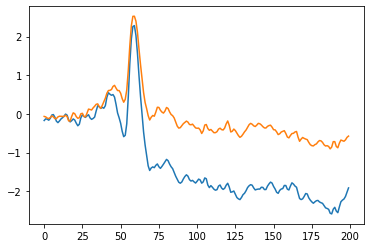

In [16]:
f, ax = plt.subplots()
ax.plot(np.mean(new_snips, axis=0)*100)
ax.plot(np.mean(d['snips_distractors']['filt_z'], axis=0))

d['filt_sd']

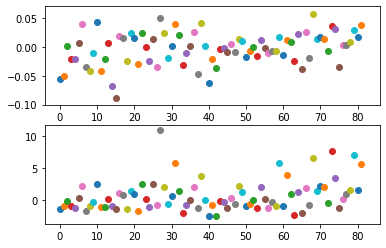

In [21]:
f, ax = plt.subplots(nrows=2)

new_snips_peak=[]
for x, snip in enumerate(new_snips):
    ax[0].scatter(x, np.mean(snip[50:80]))
    new_snips_peak.appoend()
    
for x, snip in enumerate(d['snips_distractors']['filt_z']):
    ax[1].scatter(x, np.mean(snip[50:80]))

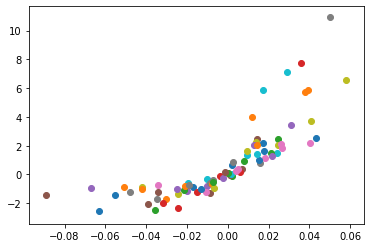

In [22]:
# This figure shows that, largely, whether we use SD from entire session or SD from individual trials we get a similar result

f, ax = plt.subplots()

for x, y in zip(new_snips, d['snips_distractors']['filt_z']):
    ax.scatter(np.mean(x[50:80]), np.mean(y[50:80]))

In [25]:
def remcheck(val, range1, range2):
    # function checks whether value is within range of two decimels
    if (range1 < range2):
        if (val > range1) and (val < range2):
            return True
        else:
            return False
    else:
        if (val > range1) or (val < range2):
            return True
        else:
            return False

In [27]:
def distractionCalc2(licks, pre=1, post=1):
    """
    Works out from list of lick timestamps when distractors should occur
    """
    
    licks = np.insert(licks, 0, 0)
    b = 0.001
    d = []
    idx = 3
    
    while idx < len(licks):
        if licks[idx]-licks[idx-2] < 1 and remcheck(b, licks[idx-2] % 1, licks[idx] % 1) == False:
            d.append(licks[idx])
            b = licks[idx] % 1
            idx += 1
            try:
                while licks[idx]-licks[idx-1] < 1:
                    b = licks[idx] % 1
                    idx += 1
            except IndexError:
                pass
        else:
            idx +=1
            
    if d[-1] > 3599:
        d = d[:-1]
    
    return d

In [31]:
def distracted_or_not(distractors, licks, delay=1):   
    pdp = [] # post-distraction pause
    pre_dp = [] # pre-distraction pause
    distractedArray = []

    for d in distractors:               
        try:
            pdp.append([lick - d for lick in licks if (lick > d)][0])
        except IndexError:
            pdp.append(3600-d) # designates end of session as max pdp
            
        distractor_index = [idx for idx, lick in enumerate(licks) if lick == d][0]
        try:
            pre_dp.append(-[ili for ili in np.diff(licks[distractor_index::-1]) if ili < -1][0])
        except IndexError:
            pre_dp.append(licks[0])
            

    distracted_boolean_array = np.array([i>delay for i in pdp], dtype=bool)
    
    distracted = [d for d,l in zip(distractors, distracted_boolean_array) if l]
    notdistracted = [d for d,l in zip(distractors, distracted_boolean_array) if not l] 
    
    if np.isnan(pdp)[-1] == 1: 
        distracted_boolean_array[-1] = True
    
    return [distracted, notdistracted], distracted_boolean_array, pdp, pre_dp

In [32]:
dis = distractionCalc2(d['licks'])

In [33]:
print(len(dis), len(d['distractors']))

59 59


In [36]:
len(distracted_or_not(dis, d['licks'])[3])

59

In [34]:
distractor_indices = []
for dis in ds:
    distractor_indices.append([idx for idx, lick in enumerate(licks) if lick == dis][0])
    
distractor_indices

[4, 12, 15, 20, 23, 26, 29, 32, 35]

In [38]:
pre_dp=[]
for d_ind in distractor_indices:
    pre_dp.append(-[ili for ili in np.diff(licks[d_ind::-1]) if ili < -1][0])

4
12
15
20
23
26
29
32
35


In [39]:
pre_dp

[85.26757888,
 71.28481791999997,
 36.02726912000003,
 26.54355456000002,
 26.075299840000014,
 4.6609203200000024,
 4.217896959999962,
 101.19430144,
 6.447923199999991]

In [ ]:
pre_dp=[]
for d_ind in distractor_indices:
    [lick for idx, lick in enumerate(licks) if lick]